### Step 6: Compute topographic surface $S(d,u,v)$ from topographic binary segmentation

Using the topographic space $(d,u,v)$ constructed from step 5, we can extract the topographic surface $S(d,u,v)$ of the input surface, $S(x,y,z)$ by mapping its binary volume segmentation $B(V(x,y,z))$ into the topography space, then apply surface meshing. This works because the interior of the cell is infilled.

Alternatively, one could map the intensities of the original image into topographic space and segment this image to obtain a binary segmentation, then surface mesh.

#### 1. Load $V(d,u,v)$, and the original binary cell segmentation 

We assume the user has worked through step 5 which generated the topographic volume space $V(d,u,v)$ in the folder `example_results/bleb_example/step5_topographic_space`. We also need the original image in the folder `../../example_data/img` and its binary segmentation in `example_data/step0_cell_segmentation`. 

In [67]:
import unwrap3D.Utility_Functions.file_io as fio
import unwrap3D.Mesh.meshtools as meshtools
import numpy as np
import os 
import skimage.io as skio 
import scipy.io as spio

# example cell used
imgfolder = '../../data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')
basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

# create the analysis save folder for this step
savefolder = os.path.join('example_results', 
                         basefname,
                         'step6_topographic_surface_mesh')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


"""
Loading
"""
# original image
img_file = '../../data/img/%s.tif' %(basefname)
img = skio.imread(img_file)

# binary segmentation
img_folder = 'example_results/%s/step0_cell_segmentation' %(basefname)
binary_file = os.path.join(img_folder, 
                            '%s_binary_seg.tif' %(basefname)) 
binary_img = skio.imread(binary_file)>0

# load the pre-computed topographic space, V(d,u,v)
topography_folder = 'example_results/%s/step5_topographic_space' %(basefname)
topography_file = os.path.join(topography_folder, 
                       'topographic_volume_space.mat')
topography_obj = spio.loadmat(topography_file) # reads the .mat like a python dictionary. 
topographic_coordinates = topography_obj['topographic_map'].copy()

#### 2. Map binary segmentation $B(V(x,y,z))$ into the topographic coordinate space $(d,u,v)$

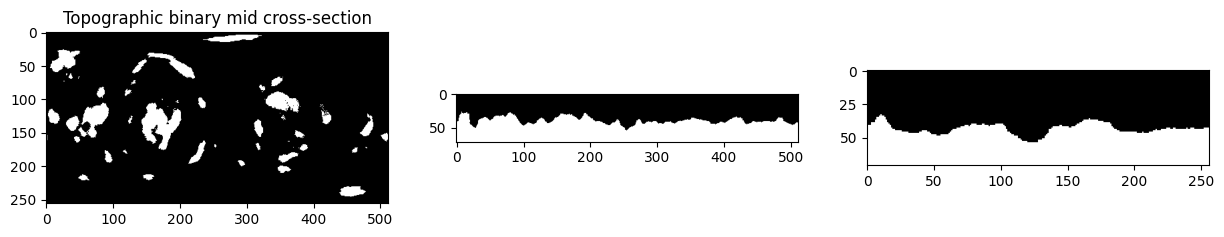

In [68]:
# convert binary to float and use linear interpolation to map the binary segmentation into topographic space
import unwrap3D.Image_Functions.image as image_fn
import pylab as plt 

# note: remember to invert coordinates, if mesh was extracted from the image transpose
topographic_binary = image_fn.map_intensity_interp3(topographic_coordinates.reshape(-1,3)[...,::-1], 
                                                    grid_shape=binary_img.shape, 
                                                    I_ref=(binary_img>0)*255.) / 255. > 0.5
topographic_binary = topographic_binary.reshape(topographic_coordinates.shape[:-1])
topography_size = topographic_binary.shape[:3]

# visualize the mid cross sections of topographic and original cartesian.
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Topographic binary mid cross-section')
plt.imshow(np.rot90(topographic_binary[topography_size[0]//2,:,:],2), cmap='gray')
plt.subplot(132)
plt.imshow(np.rot90(topographic_binary[:,topography_size[1]//2,:],2), cmap='gray')
plt.subplot(133)
plt.imshow(np.rot90(topographic_binary[:,:,topography_size[2]//2],2), cmap='gray')
plt.show()


#### 3. Mesh the topographic binary segmentation to obtain topographic surface mesh $S(d,u,v)$

In [69]:
# we mesh and keep the largest connected component
topographic_mesh = meshtools.marching_cubes_mesh_binary(topographic_binary,   
                                                        presmooth=1., # applies a presmooth
                                                        contourlevel=.5, # isosurface level to mesh
                                                        keep_largest_only=True, # we want the largest connected component 
                                                        remesh=True,
                                                        remesh_method='CGAL', 
                                                        remesh_samples=.5, # remeshing with a target #vertices = 50% of original
                                                        predecimate=False, # must be True if using remesh_method='pyacvd'
                                                        min_mesh_size=10000,
                                                        upsamplemethod='inplane') # upsample the mesh if after the simplification and remeshing < min_mesh_size  

# check the orientation
if np.sign(topographic_mesh.volume) < 0:
    topographic_mesh.faces = topographic_mesh.faces[:,::-1]


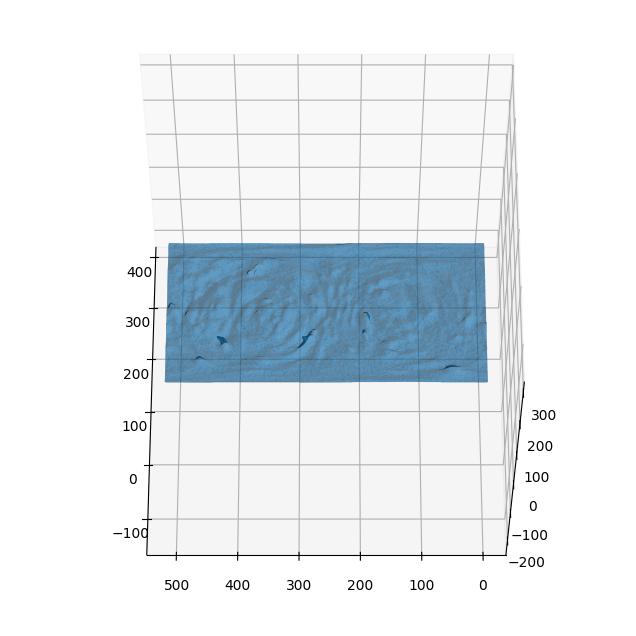

In [70]:
# visualize in matplotlib 
import unwrap3D.Visualisation.plotting as plotting

# plot the mesh - not very exciting at the moment due to lack of colors. 
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8,8))
ax.set_box_aspect(aspect = (1,1,1))
ax.plot_trisurf(topographic_mesh.vertices[...,1], 
                topographic_mesh.vertices[...,2], 
                topographic_mesh.vertices[...,0],
                triangles=topographic_mesh.faces)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
plt.show()


#### 4. Map surface curvature and molecular intensities onto topographic surface mesh $S(d,u,v)$

We can compute the surface curvature and molecular intensities in Cartesian space and map this to $S(d,u,v)$ thanks to the bijective mapping.

We map the vertices of $S(d,u,v)$ to Cartesian $(x,y,z)$ space, and interpolate the curvature and molecular intensities

In [71]:
# transforming the vertices of the topography mesh to Cartesian (x,y,z) space
import unwrap3D.Analysis_Functions.topography as topo_tools

topography_verts_xyz = topo_tools.uv_depth_pts3D_to_xyz_pts3D( topographic_mesh.vertices, 
                                                               topographic_coordinates)

In [72]:
import unwrap3D.Segmentation.segmentation as segmentation
import unwrap3D.Visualisation.colors as vol_colors
from matplotlib import cm 

# Compute the continuous mean curvature from the binary cell segmentation as for S(x,y,z) 
H_binary, H_sdf_vol_normal, H_sdf_vol = segmentation.mean_curvature_binary(binary_img.transpose(2,1,0), 
                                                                           smooth=3, 
                                                                           mask=False) # if mask=True, only the curvature of a thin shell (+/-smooth) around the binary segmentation is returned. 

# interpolate the value onto the topographic mesh. Note: inversion of points to match the image dimensions (the mesh was derived after transposing the binary)
topo_surf_H = image_fn.map_intensity_interp3(topography_verts_xyz, 
                                            grid_shape= H_binary.shape, 
                                            I_ref= H_binary, 
                                            method='linear', 
                                            cast_uint8=False)

# we generate colors from the mean curvature 
topo_surf_H_colors = vol_colors.get_colors(topo_surf_H/.104, # 0.104 is the voxel resolution -> this converts to um^-1 
                                          colormap=cm.Spectral_r, 
                                          vmin=-1., 
                                          vmax=1.) # colormap H with lower and upper limit of -1, 1 um^-1. 

# set the vertex colors to the computed mean curvature color
topographic_mesh.visual.vertex_colors = np.uint8(255*topo_surf_H_colors[...,:3]) 

# save the mesh for viewing in an external program such as meshlab which offers much better rendering capabilities
tmp = topographic_mesh.export(os.path.join(savefolder, 
                                           'curvature_topographic_mesh_'+basefname+'.obj')) # tmp is used to prevent printing to screen.

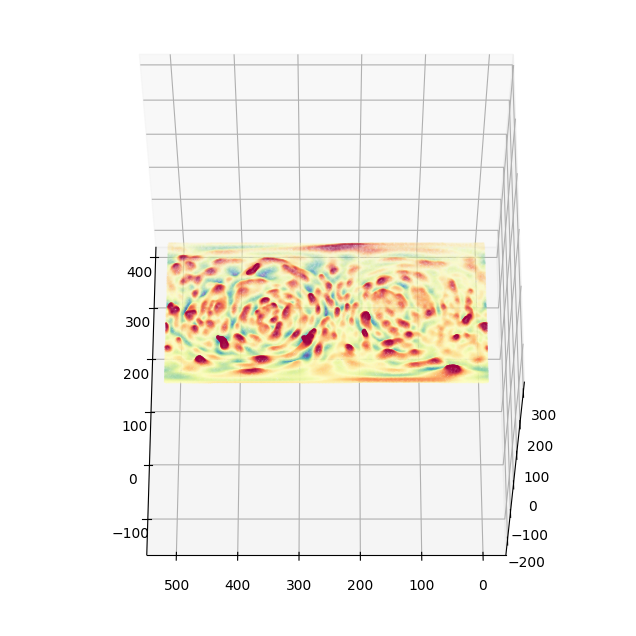

In [73]:
# visualise the topographic surface with curvature colors
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8,8))
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(topographic_mesh.vertices[...,1], 
            topographic_mesh.vertices[...,2], 
            topographic_mesh.vertices[...,0],
            c = topo_surf_H_colors, s=0.1)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
plt.show()

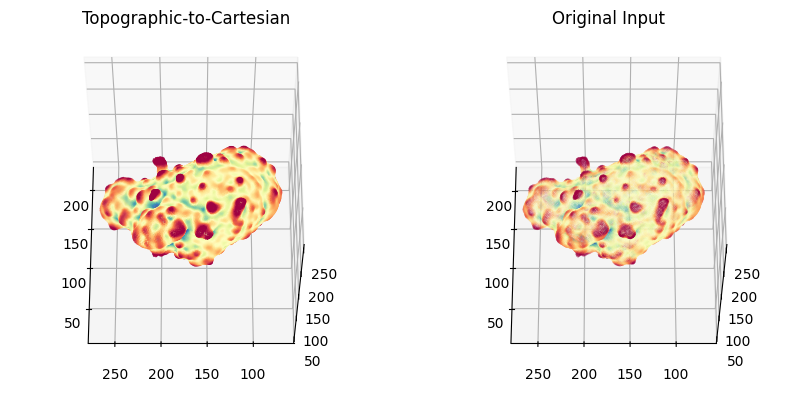

In [74]:
# we can plot this with the original surface mesh for a side-by-side comparison! - can see they are almost identical. 

# read in the cell segmentation surface
img_folder = 'example_results/%s/step0_cell_segmentation' %(basefname)
binary_file = os.path.join(img_folder, 
                            '%s_binary_seg.tif' %(basefname)) 
cartesian_surface_H = meshtools.read_mesh(os.path.join('example_results/%s/step0_cell_segmentation' %(basefname),
                                                      'curvature_binary_mesh_%s.obj' %(basefname)))

# 1. Topographic-to-Cartesian surface
fig = plt.figure(figsize=(5*2, 5))
ax = fig.add_subplot(1,2,1,projection='3d')
plt.title('Topographic-to-Cartesian')
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(topography_verts_xyz[...,0], 
            topography_verts_xyz[...,1], 
            topography_verts_xyz[...,2],
            c = topo_surf_H_colors, s=0.5) # use a larger size, as the mesh is smaller.
ax.view_init(60,180)
plotting.set_axes_equal(ax)

# 2. Original-Cartesian surface
ax = fig.add_subplot(1,2,2,projection='3d')
plt.title('Original Input')
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(cartesian_surface_H.vertices[...,0], 
            cartesian_surface_H.vertices[...,1], 
            cartesian_surface_H.vertices[...,2],
            c = cartesian_surface_H.visual.vertex_colors[:,:3]/255., s=0.1)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
plt.show()


Similarly we can map the volumetric image intensity. As in Step 0 we will sample $1\mu m$ along the steepest gradient of the signed distance transform into the cell to derive the surface proximal molecular intensity

In [79]:
"""
Mapping the molecular intensity up to 1um onto the topographic surface. This involves:

1) deforming the surface at increments up to depth of 1um normal into cell
2) taking an average of the intensities sampled 
"""

"""
1. propagate the mesh.
"""
# create the surface mesh, of the topographic mapped back into Cartesian 3D. 
topo_cartesian_mesh = meshtools.create_mesh(vertices=topography_verts_xyz, # just change the vertices, the faces does not change.
                                            faces=topographic_mesh.faces)

# check and invert the faces so the coloring is correct.
if np.sign(topo_cartesian_mesh.volume)<0:
    topo_cartesian_mesh.faces = topo_cartesian_mesh.faces[...,::-1]

n_samples = 1./ .104 # total number of steps. 0.104 is the voxel size in microns
stepsize = 0.5 # voxels

# run the active contour cMCF or active contours to get the coordinates at different depths into the cell according to the external image gradient given by the gradient of the signed distance function.
v_depth = meshtools.parametric_mesh_constant_img_flow(topo_cartesian_mesh, 
                                                      external_img_gradient = H_sdf_vol_normal.transpose(1,2,3,0), # the inversion is because  
                                                      niters=int(n_samples/stepsize), 
                                                      deltaL=5e-5, # delta which controls the stiffness of the mesh
                                                      step_size=stepsize, 
                                                      method='implicit', # this specifies the cMCF solver.
                                                      conformalize=True) # if False, then uses active contours which has parameters of gamma, alpha, beta



100%|██████████| 19/19 [00:02<00:00,  6.80it/s]


In [80]:
"""
2. sample intensity at propogated points and take average 
"""

# since the mesh is derived from the transposed binary, we need to remember to invert the coordinates when getting the image intensity
# get the intensities at the sampled depth coordinates. 
topo_v_depth_I = image_fn.map_intensity_interp3(v_depth.transpose(0,2,1).reshape(-1,3)[...,::-1], 
                                            img.shape, 
                                            I_ref=img)
topo_v_depth_I = topo_v_depth_I.reshape(-1,v_depth.shape[-1]) # matrix reshaping into a nicer shape. 

# postprocess to check the total distance from the surface does not exceed the desired and replace any nans.  
dist_v_depth0 = np.linalg.norm(v_depth - v_depth[...,0][...,None], axis=1)
valid_I = dist_v_depth0<=n_samples
topo_v_depth_I[valid_I == 0 ] = np.nan # replace with nans

# compute the mean sampled intensity which will be taken as the surface intensity. 
topo_surf_intensity_img_raw = np.nanmean(topo_v_depth_I, axis=1)
topo_surf_intensity_img_raw[np.isnan(topo_surf_intensity_img_raw)] = 0

print(np.min(topo_surf_intensity_img_raw), np.max(topo_surf_intensity_img_raw))

"""
# for visualization, we find the intensity range to be more pleasing if clipped to between the 1st and 99th percentile. 
# NOTE: we need to match the original intensity statistics to have identical visualisation ! 
"""
import scipy.io as spio 

curvature_intensity_stats = spio.loadmat(os.path.join('example_results/%s/step0_cell_segmentation' %(basefname),
                                                      '%s_surface_curvature_intensity_stats' %(basefname)))
I_min = np.percentile(curvature_intensity_stats['surf_intensity'][0],1)
I_max = np.percentile(curvature_intensity_stats['surf_intensity'][0],99)

print(np.min(curvature_intensity_stats['surf_intensity'][0]), np.max(curvature_intensity_stats['surf_intensity'][0]))

topo_surf_intensity_img_raw_colors = vol_colors.get_colors(topo_surf_intensity_img_raw, 
                                                      colormap=cm.RdYlBu_r,   
                                                      vmin=I_min, 
                                                      vmax=I_max)

# create a new topograpphic surface mesh, now with the PI3K molecular signal colors. 
topographic_surf_mesh_colors = meshtools.create_mesh(vertices=topographic_mesh.vertices,
                                                      faces=topographic_mesh.faces, 
                                                      vertex_colors=np.uint8(255*topo_surf_intensity_img_raw_colors[...,:3])) 
tmp = topographic_surf_mesh_colors.export(os.path.join(savefolder, 
                                                'PI3K_topographic_mesh_'+basefname+'.obj')) # tmp is used to prevent printing to screen.


26.45389435909244 214.38372550406132
17.91748408400944 209.24241005020332


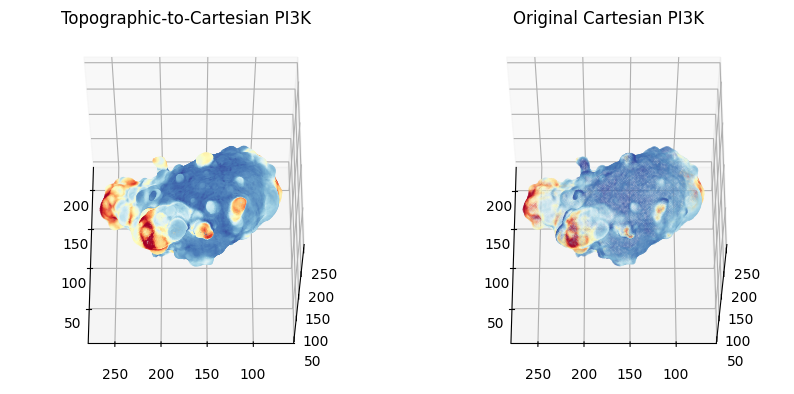

In [81]:
# again we can show a side-by-side comparison of the sampled molecular intensity! - they are almost identical. 

# read in the cell segmentation surface
img_folder = 'example_results/%s/step0_cell_segmentation' %(basefname)
binary_file = os.path.join(img_folder, 
                            '%s_binary_seg.tif' %(basefname)) 
cartesian_surface_PI3K = meshtools.read_mesh(os.path.join('example_results/%s/step0_cell_segmentation' %(basefname),
                                                      'PI3K_binary_mesh_%s.obj' %(basefname)))

fig = plt.figure(figsize=(5*2,5))
# 1. Topographic-to-Cartesian surface PI3K intensity
ax = fig.add_subplot(1,2,1,projection='3d')
plt.title('Topographic-to-Cartesian PI3K')
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(topography_verts_xyz[...,0], 
            topography_verts_xyz[...,1], 
            topography_verts_xyz[...,2],
            c = topo_surf_intensity_img_raw_colors, s=0.5) # use a larger size, as the mesh is smaller.
ax.view_init(60,180)
plotting.set_axes_equal(ax)

# 2. Original-Cartesian surface
ax = fig.add_subplot(1,2,2,projection='3d')
plt.title('Original Cartesian PI3K')
ax.set_box_aspect(aspect = (1,1,1))
ax.scatter(cartesian_surface_PI3K.vertices[...,0], 
            cartesian_surface_PI3K.vertices[...,1], 
            cartesian_surface_PI3K.vertices[...,2],
            c = cartesian_surface_PI3K.visual.vertex_colors[:,:3]/255., s=0.1)
ax.view_init(60,180)
plotting.set_axes_equal(ax)
plt.show()